# Interpreting Machine Learning Models Using LIME

Understanding why models make certain predictions is crucial, especially as AI begins to take on decision-making roles in fields like law, healthcare, and entertainment. Unlike humans, AI models lack transparency; we can’t directly question them to reveal their reasoning, nor can we hold them accountable. This makes interpretability essential for trust and responsible use.

Consider banking: AI models assess creditworthiness based on factors like age, income, and existing debt. If an applicant with a high score requests a large loan, analysts want to ensure the model’s prediction reflects actual repayment ability, not data or model flaws. Misjudgments here can be costly for banks, impacting finances and reputations.

AI influences decisions in many areas—marketing recommendations, medical diagnoses, and gamer matchmaking. Ensuring we understand these models’ decision processes is vital as their use grows across daily life.

## The Trade-Off Between Prediction Accuracy and Model Interpretability

In general, complex models tend to be more accurate but harder to interpret. For example, we can easily understand how changing an input affects predictions in a linear regression model. However, when relationships are nonlinear, we may need to use more complex models like gradient-boosted trees, which are harder to interpret.

This accuracy-interpretability trade-off means that while advanced models can capture complex patterns, they often sacrifice transparency. Balancing accuracy and interpretability is key in choosing the right model for a task.

## What is LIME?

Historically, the trade-off between model accuracy and interpretability was seen as unavoidable. However, methods like **Local Interpretable Model-agnostic Explanations (LIME)**, proposed by Marco Tulio Ribeiro in 2016, have provided ways to understand the predictions of even the most complex models.

### How LIME Works
LIME uses simple, interpretable models to locally explain predictions made by complex models. To use LIME, we need:
1. A model we can query multiple times.
2. A model with a `predict_proba` method (for compatibility with LIME).

LIME assumes the model we want to explain takes in features (like numbers, text, or images) to make predictions and can be probed as often as needed. LIME fits an interpretable model to a dataset generated by slightly modifying a single observation.

### Steps in LIME
1. **Perturb the Data:** Starting with one observation, LIME iteratively removes parts of it to create “perturbed” observations.
2. **Generate Predictions:** The model makes predictions on these perturbed observations.
3. **Fit an Interpretable Model:** An interpretable model (such as linear regression) is fit to the predictions of the perturbed dataset, locally explaining the original model’s behavior.

#### Example
Consider an NLP model that predicts the sentiment of a sentence. LIME would create a set of slightly modified versions of that sentence, generate predictions, and fit a simple model to show how different words affect the prediction.

This approach allows us to understand complex models' decisions, making AI more transparent and trustworthy.

| Input                                   | Components removed | Similarity to original | Prediction |
|-----------------------------------------|--------------------|------------------------|------------|
| The quick brown fox jumps over the lazy dog | -                  | 100%                   | 0.42       |
| The brown fox jumps over the lazy dog   | quick             | 89%                    | 0.51       |
| The quick fox jumps over the lazy dog   | brown             | 89%                    | 0.42       |
| The fox jumps over the lazy dog         | quick, brown      | 78%                    | 0.55       |
| The quick brown fox jumps over the dog  | lazy              | 89%                    | 0.00       |

As shown in the table, removing the word “lazy” reduced the predicted score to zero, while other word removals had minimal impact on the model's prediction. LIME leverages this by fitting a simple model, like a decision tree or linear regression, on the perturbed dataset to reveal which components most influence the original prediction. The “Similarity to original” column represents the proportion of words from the initial observation included in each perturbation, and these values are used as weights for fitting the simple model.

### Explanation Across Different Data Types
- **NLP:** Perturbations involve removing or altering words in the text, as demonstrated in the table.
- **Tabular Data:** Perturbations are created by slightly modifying the values of the input vector.
- **Images:** Perturbations involve graying out sections of the image (contiguous pixels) and making predictions on the modified image.

### Local Explanations in LIME
LIME provides explanations for a single observation (local explanation) rather than for all possible observations (global explanation). This approach explains the model's prediction based on the specific set of inputs, making it useful for understanding decisions at a granular level.

### LIME in Python
We will now use LIME to explain the vaderSentiment model. First, install and import both modules: 

In [1]:
# Install dependencies for LIME and Vader sentiment analysis
!pip install lime
!pip install vaderSentiment

In [2]:
# Import Vader sentiment analysis model to analyze sentiment scores in text
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Import LIME for explaining individual text predictions of a model
from lime.lime_text import LimeTextExplainer

# Import numpy for numerical operations and formatting
import numpy as np

For each text, Vader returns a dictionary with the text’s negative, positive, neutral, and compound scores. Although LIME is model-agnostic (i.e., it can work with any model), it requires the model to have a structure similar to an `sklearn` object. Specifically, the model needs a `predict_proba` method. Therefore, we will modify Vader to make it resemble an `sklearn` instance.

In [3]:
# Define a function that allows Vader to score multiple texts at once and return probabilities
def predict_proba(self, texts):

    # Initialize an empty list to store prediction results for each text
    ret = []

    # Iterate over each text in the input list
    for text in texts:

        # Get the negative sentiment score for the current text using Vader's polarity_scores method
        # The polarity_scores method returns a dictionary with 'neg', 'neu', 'pos', and 'compound' keys
        # We are specifically extracting the 'neg' (negative) score here
        neg = self.polarity_scores(text).get('neg')

        # Append a list of two values to ret:
        # - The first value is the negative score (neg)
        # - The second value is 1 - neg, which represents the probability of the text being positive/neutral
        # This two-element list simulates probability output required by LIME's `predict_proba` format
        ret.append([neg, 1 - neg])

    # Convert the list of predictions (ret) to a NumPy array and return it
    # LIME requires predictions in a structured array format, which is why we use np.array here
    return np.array(ret)

# Add the predict_proba function to the SentimentIntensityAnalyzer class as a new method
# This allows our Vader model instance to use predict_proba just like a scikit-learn model would
SentimentIntensityAnalyzer.predict_proba = predict_proba

# Instantiate the modified SentimentIntensityAnalyzer model
# The Vader model now includes the predict_proba method, making it compatible with LIME
vader = SentimentIntensityAnalyzer()

In [4]:
# Declare the text for which we want to explain the sentiment prediction
# The text represents a negative sentiment, with the user expressing frustration about Mondays.
my_angry_text = 'I HATE Mondays! I missed the bus and forgot my lunch...'

# Instantiate the LimeTextExplainer
# The explainer is initialized with the 'class_names' parameter, which specifies the names of the two classes we are predicting: 'negative' and 'not-negative'.
# This helps to make the result look more user-friendly when interpreting the model's output.
explainer = LimeTextExplainer(
    class_names=[
        'negative',     # Class name for negative sentiment
        'not-negative'  # Class name for sentiments that are not negative
    ]
)

# Create an explanation for the text using LIME
# `explain_instance` explains the model's prediction for a specific text.
# - `My_angry_text`: The text input for which we want an explanation.
# - `Vader.predict_proba`: The model's prediction function (the modified Vader model with predict_proba).
# - `num_features=4`: Specifies the number of most important features (words) to consider when generating the explanation. Here, we are explaining the top 4 features.
explanation = explainer.explain_instance(
    my_angry_text,  # Input text to be explained
    vader.predict_proba,  # Model's prediction function
    num_features=4  # Limit the explanation to the top 4 most influential features
)

In [5]:
explanation.show_in_notebook()

### The Final Prediction Probabilities Across Classes:

- **not-negative**: 0.56 (56%)
- **negative**: 0.43 (43%)

---

### Feature Importance Visualization:

The feature importance visualization shows how each word contributes to either class:
- The **blue bars** (representing the negative class) indicate the strongest negative contributors, with "HATE" and "missed" being the most significant.
- The **orange bars** (representing the not-negative class) show small contributions from words like "I" and "forgot."
- The **length of each bar** represents the magnitude of that feature's contribution to the respective class.

---

### The Actual Text with Highlighted Words:

The text with the words that LIME identified as most influential in the model's decision will be displayed with highlighted words. These words are the ones that had the most impact on the model’s prediction, either contributing to the negative sentiment or not-negative sentiment.

### Model's Prediction Seems Counter-Intuitive and Possibly Incorrect

The sentence should have a much higher negative probability. Below are the strong negative indicators in the text:

### Strong Negative Indicators in the Text:
- **"HATE"** (in all caps, suggesting strong emphasis)
- **"missed the bus"** (negative experience)
- **"forgot my lunch"** (another negative experience)
- **Multiple negative events** chained together with "and"
- **Exclamation mark** after "HATE", suggesting strong emotion

### Common Sense Interpretation:
- The sentence expresses **clear frustration**.
- It contains **multiple negative experiences**.
- **"I HATE Mondays!"** is a classic expression of **strong negative sentiment**.
- There are **no positive or mitigating words/phrases** to offset the negativity.

### Potential Issues with the Model:
- It might be **underweighting the intensity of capitalized words**.
- The model could be **failing to properly combine multiple negative events**.
- It might not be properly calibrated for **casual expressions of frustration**.
- The model could be **biased by training data** where "hate" is used more casually.

### Expected Behavior:
We would expect a well-calibrated sentiment model to assign a much higher probability (like **90%**) to the negative class for this text. 

### LIME's Role in Identifying Model Limitations:
This LIME output might be revealing a potential problem with the underlying model's ability to properly assess **strong negative sentiment** or handle **multiple negative events in combination**. 

This is exactly why tools like LIME are **valuable** — they help us identify when models are making counterintuitive decisions that might need **investigation or improvement**.

# Bias detection and mitigation using a loan approval dataset

In [7]:
!pip install aif360

In [9]:
!pip install 'aif360[AdversarialDebiasing,Reductions,inFairness]'

  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 MB 39.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 37.3 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 37.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 35.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 34.1 MB/s eta 0:00:00
Using cached rich-13.9.4-py3-none-any.whl (242 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 8.4 MB/s eta 0:00:00


In [1]:
# Importing essential libraries for data manipulation, machine learning, and fairness analysis

# pandas: Provides data structures like DataFrame for data manipulation and analysis.
import pandas as pd

# numpy: Supports numerical operations and handling of multi-dimensional arrays and matrices.
import numpy as np

# sklearn.model_selection: train_test_split is used for splitting the dataset into training and test sets.
from sklearn.model_selection import train_test_split

# sklearn.preprocessing: 
# StandardScaler is used for feature scaling, ensuring the data has a mean of 0 and standard deviation of 1.
# LabelEncoder is used for converting categorical variables into numeric values.
from sklearn.preprocessing import StandardScaler, LabelEncoder

# sklearn.ensemble: RandomForestClassifier is an ensemble model used for classification tasks. It is based on creating a collection of decision trees.
from sklearn.ensemble import RandomForestClassifier

# matplotlib.pyplot: Used for creating static, interactive, and animated visualizations, e.g., plots for performance evaluation.
import matplotlib.pyplot as plt

# seaborn: Built on top of matplotlib, seaborn simplifies the creation of statistical graphics like heatmaps, bar charts, and more.
import seaborn as sns

# aif360.datasets: BinaryLabelDataset is a class in AIF360 that represents datasets with binary labels and protected attributes for fairness evaluation.
from aif360.datasets import BinaryLabelDataset

# aif360.metrics: BinaryLabelDatasetMetric calculates fairness metrics like disparate impact, statistical parity, and others based on a dataset.
from aif360.metrics import BinaryLabelDatasetMetric

# aif360.algorithms.preprocessing: 
# Reweighing adjusts the weights of the samples in the training data to achieve fairness across different groups.
from aif360.algorithms.preprocessing import Reweighing

# DisparateImpactRemover modifies the features of the dataset to reduce disparate impact across different groups based on sensitive attributes.
from aif360.algorithms.preprocessing import DisparateImpactRemover

/Users/tanyakhanna/mambaforge/envs/myenv/lib/python3.12/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/Users/tanyakhanna/mambaforge/envs/myenv/lib/python3.12/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.ht

In [2]:
# Function to create a synthetic loan approval dataset with controlled bias
# This function generates a synthetic dataset with the specified number of samples (default is 1000)
# It includes features like age, income, credit score, gender, and education level, and introduces bias based on these features.

def create_synthetic_loan_data(n_samples=1000):
    # Set the random seed to ensure reproducibility of the dataset
    np.random.seed(42)

    # Generate synthetic data using normal distributions for numeric variables (age, income, and credit score),
    # and random choices for categorical variables (gender and education).
    data = {
        'age': np.random.normal(40, 10, n_samples),  # Age: normally distributed with mean 40 and standard deviation 10
        'income': np.random.normal(60000, 20000, n_samples),  # Income: normally distributed with mean 60,000 and std deviation 20,000
        'credit_score': np.random.normal(700, 50, n_samples),  # Credit score: normally distributed with mean 700 and std deviation 50
        'gender': np.random.choice(['M', 'F'], n_samples),  # Gender: randomly chosen between 'M' (male) and 'F' (female)
        'education': np.random.choice(['Bachelor', 'Master', 'PhD'], n_samples)  # Education: randomly chosen from 'Bachelor', 'Master', 'PhD'
    }

    # Convert the data dictionary into a pandas DataFrame for easier manipulation
    df = pd.DataFrame(data)

    # Introduce bias in the loan approval process:
    # - Increase the probability of loan approval for applicants with higher income, higher credit scores, and male applicants.
    # The probability of loan approval is a function of these factors, with base probability of 0.4 (40% approval chance).
    prob_approval = (
        0.4 +  # Base probability of 40% for approval
        0.3 * (df['income'] > 60000) +  # +30% if income is greater than 60,000
        0.2 * (df['credit_score'] > 700) +  # +20% if credit score is greater than 700
        0.1 * (df['gender'] == 'M')  # +10% if gender is male (M)
    )

    # Use a binomial distribution to simulate loan approval based on the computed probabilities.
    # 1 means loan is approved, 0 means loan is not approved.
    df['loan_approved'] = np.random.binomial(1, prob_approval)

    # Return the generated dataset (DataFrame)
    return df

# Bias Detection Metrics

## 1. Basic Approval Rate Analysis
- **Definition**: This metric simply looks at how many loans were approved for each group (e.g., male and female applicants).
- **Purpose**: To check if one group is more likely to get approved for a loan compared to another group.
- **How it works**: It groups the data by the protected attribute (e.g., gender) and calculates the average approval rate (the percentage of approved loans) for each group.
- **Example**: If male applicants have a loan approval rate of 80% and female applicants have a loan approval rate of 50%, this shows a potential bias favoring males.

---

## 2. Statistical Parity
- **Definition**: Statistical Parity checks whether the approval rates for different groups (e.g., males and females) are similar or different.
- **Purpose**: To determine if the decision-making process treats different groups equally, based on the protected attribute (e.g., gender).
- **How it works**: It calculates the approval rate for each group and finds the difference between the highest and lowest approval rates.
- **Example**: If the approval rate for male applicants is 70% and for female applicants is 50%, the statistical parity difference would be 20%. A large difference indicates bias.

---

## 3. Disparate Impact
- **Definition**: Disparate Impact measures whether one group is disproportionately impacted by the decision-making process compared to another group.
- **Purpose**: To check if one group is unfairly favored or disadvantaged in the decision-making process, regardless of qualifications.
- **How it works**: It calculates the ratio of the approval rate of the least favored group to the most favored group. A ratio of 1 indicates fairness, while a ratio less than 1 suggests bias.
- **Example**: If the approval rate for males is 80% and for females is 40%, the disparate impact ratio is 0.5 (40%/80%). A ratio significantly less than 1 suggests that females are disadvantaged.

---

## 4. Feature Correlation Analysis
- **Definition**: This metric looks at how strongly each feature (e.g., age, income, credit score) is related to the protected attribute (e.g., gender or race).
- **Purpose**: To see if any features are unfairly associated with the protected attribute, which could lead to indirect bias in decision-making.
- **How it works**: It calculates how each feature is correlated with the protected attribute. High correlation means that the feature might be unintentionally influencing the decision process based on the protected attribute.
- **Example**: If income is highly correlated with gender (e.g., men having higher incomes), the model might indirectly favor men based on income.

---

## 5. Conditional Approval Rate Analysis
- **Definition**: This metric analyzes how loan approval rates vary across different groups when considering other features, such as income or credit score.
- **Purpose**: To see if certain groups (e.g., males and females) have different approval rates even when their income or credit score is taken into account.
- **How it works**: It visualizes the distribution of features like income, credit score, and age by approval status, for each protected group (e.g., gender).
- **Example**: If males with a credit score over 700 are approved at a higher rate than females with the same score, there might be bias in how the approval process is applied, even if the credit score is the same.

---

## 6. Intersectional Analysis
- **Definition**: Intersectional Analysis looks at how multiple protected attributes (e.g., gender and education) combined affect loan approval rates.
- **Purpose**: To understand how combinations of factors (e.g., female PhD holders vs. male PhD holders) impact the likelihood of approval.
- **How it works**: It creates new groups based on combinations of protected attributes (e.g., "PhD_Male", "Bachelor_Female") and compares approval rates across these combined groups.
- **Example**: If female PhD holders are approved at a lower rate than male PhD holders, there could be an intersectional bias affecting both gender and education level.

In [3]:
# Function to detect and analyze bias in the loan approval dataset
# This function performs a comprehensive bias detection analysis by calculating various fairness metrics and visualizing the results.
# It also handles categorical variables by encoding them before analyzing correlations.

def detect_bias(df, protected_attribute='gender', outcome='loan_approved'):
    """
    Comprehensive bias detection analysis with proper handling of categorical variables
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset
    protected_attribute : str
        Name of the protected attribute column (default: 'gender')
    outcome : str
        Name of the outcome column (default: 'loan_approved')
    """
    print("\n=== Comprehensive Bias Detection Analysis ===")
    
    # 1. Basic Approval Rate Analysis
    # This step calculates the approval rate for each group (e.g., males vs. females) based on the protected attribute (e.g., gender).
    print("\n1. Basic Approval Rates by Group:")
    approval_rates = df.groupby(protected_attribute)[outcome].agg(['count', 'mean'])  # Group by protected attribute and calculate the count and mean approval rate
    print(approval_rates)  # Print the results
    
    # Visualize the approval rates using a barplot to show the approval rates by each group
    plt.figure(figsize=(10, 6))
    sns.barplot(x=protected_attribute, y=outcome, data=df)  # Bar plot to show the approval rate by group
    plt.title(f'Loan Approval Rates by {protected_attribute}')
    plt.show()
    
    # 2. Statistical Parity
    # Statistical Parity measures the difference in approval rates between groups.
    def calculate_statistical_parity():
        # Get the unique values of the protected attribute (e.g., male and female)
        groups = df[protected_attribute].unique()
        approval_rates_dict = {}  # Create a dictionary to store approval rates for each group
        for group in groups:
            group_df = df[df[protected_attribute] == group]  # Subset the data by group
            approval_rates_dict[group] = group_df[outcome].mean()  # Calculate the approval rate for each group
        
        # Calculate the difference between the highest and lowest approval rates
        stat_parity = max(approval_rates_dict.values()) - min(approval_rates_dict.values())
        return stat_parity, approval_rates_dict
    
    stat_parity, group_rates = calculate_statistical_parity()  # Get the statistical parity difference and group approval rates
    print("\n2. Statistical Parity Analysis:")
    print(f"Statistical Parity Difference: {stat_parity:.4f}")  # Print the statistical parity difference
    print("Group-wise approval rates:", group_rates)  # Print the approval rates for each group
    
    # 3. Disparate Impact
    # Disparate Impact measures whether one group is disproportionately impacted by the approval process.
    def calculate_disparate_impact():
        groups = df[protected_attribute].unique()  # Get unique groups based on protected attribute
        rates = []
        for group in groups:
            group_df = df[df[protected_attribute] == group]  # Subset data by group
            rates.append(group_df[outcome].mean())  # Store the approval rate for each group
        # Return the ratio of the approval rates between the least and most favored groups
        return min(rates) / max(rates)
    
    disparate_impact = calculate_disparate_impact()  # Calculate the disparate impact ratio
    print("\n3. Disparate Impact Analysis:")
    print(f"Disparate Impact Ratio: {disparate_impact:.4f}")  # Print the disparate impact ratio
    print("(A value of 1.0 indicates perfect fairness)")
    
    # 4. Feature Correlation Analysis
    # This analysis checks if any features in the dataset are correlated with the protected attribute, which may indicate indirect bias.
    print("\n4. Feature Correlation Analysis:")
    correlations = df.copy()  # Create a copy of the dataframe for analysis
    
    # Get numeric columns for correlation analysis
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Create a new dataframe with only the numeric columns for calculating correlations
    correlation_data = correlations[numeric_cols].copy()
    
    # Encode categorical variables (like 'gender' and 'education') to numeric values for correlation analysis
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns
    le = LabelEncoder()
    
    for col in categorical_cols:
        correlation_data[col] = le.fit_transform(correlations[col])  # Encode categorical columns
    
    # Calculate and display the correlation matrix
    correlation_matrix = correlation_data.corr()  # Get the correlation matrix
    plt.figure(figsize=(12, 8))  # Set up the figure size
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)  # Heatmap for correlation visualization
    plt.title('Feature Correlation Matrix')
    plt.show()
    
    # 5. Conditional Approval Rate Analysis
    # This step visualizes how loan approval rates vary with continuous features like income, credit score, and age across different groups.
    print("\n5. Conditional Approval Rate Analysis:")
    numeric_features = df.select_dtypes(include=[np.number]).columns  # Get numeric columns
    numeric_features = [col for col in numeric_features if col != outcome]  # Exclude the outcome column
    
    # Create boxplots to visualize the distribution of each feature across the groups
    fig, axes = plt.subplots(1, len(numeric_features), figsize=(20, 6))
    for i, feature in enumerate(numeric_features):
        sns.boxplot(x=protected_attribute, y=feature, hue=outcome, data=df, ax=axes[i])  # Boxplot for each feature
        axes[i].set_title(f'{feature} Distribution by {protected_attribute} and Approval')  # Set title
    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()
    
    # 6. Intersectional Analysis
    # This analysis looks at how combinations of protected attributes (e.g., gender and education) affect loan approval rates.
    print("\n6. Intersectional Analysis:")
    df['education_gender'] = df['education'] + '_' + df[protected_attribute]  # Combine 'education' and 'gender' for intersectionality
    intersectional_rates = df.groupby('education_gender')[outcome].agg(['count', 'mean'])  # Group by the combined attribute
    print(intersectional_rates)  # Print the intersectional analysis results
    
    # Visualize the intersectional approval rates
    plt.figure(figsize=(12, 6))
    sns.barplot(x='education_gender', y=outcome, data=df)  # Bar plot for intersectional approval rates
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability
    plt.title('Intersectional Approval Rates')
    plt.show()
    
    # 7. Calculate Bias Metrics Summary
    # Create a summary dictionary for the calculated bias metrics to make the results more accessible
    bias_metrics = {
        'statistical_parity': stat_parity,
        'disparate_impact': disparate_impact,
        'group_rates': group_rates,
        'approval_rates': approval_rates.to_dict()  # Convert approval rates to a dictionary for easy access
    }
    
    # Print summary statistics to provide an overview of the dataset and approval rates
    print("\n=== Summary Statistics ===")
    print(f"Number of applications: {len(df)}")  # Print the total number of applications
    print("\nGroup sizes:")
    print(df[protected_attribute].value_counts())  # Print the number of applicants in each group
    print("\nOverall approval rate: {:.2f}%".format(df[outcome].mean() * 100))  # Print the overall loan approval rate
    
    # Return the summary of bias metrics for further analysis
    return bias_metrics

In [4]:
def prepare_dataset_for_aif360(df):
    """
    Prepare the dataset for AIF360 library by converting categorical variables to numeric format
    and structuring the data according to AIF360's requirements.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing:
        - 'gender' (categorical: 'M'/'F')
        - 'education' (categorical)
        - 'loan_approved' (binary: 0/1)
        - other numeric features
    
    Returns:
    --------
    dataset : aif360.datasets.BinaryLabelDataset
        Dataset formatted for AIF360 bias detection and mitigation tools
    """
    # Create a deep copy to avoid modifying the original dataframe
    df_copy = df.copy()

    # One-hot encode categorical variables to ensure all features are numeric
    # Include any derived categorical columns (like 'education_gender') in the encoding
    categorical_cols = ['gender', 'education', 'education_gender']
    df_copy = pd.get_dummies(df_copy, columns=categorical_cols, drop_first=True)

    # Ensure all columns are converted to float64 for AIF360 compatibility
    df_copy = df_copy.astype(np.float64)
    
    # Create an AIF360 BinaryLabelDataset
    dataset = BinaryLabelDataset(
        df=df_copy,
        label_names=['loan_approved'],  # Outcome variable
        protected_attribute_names=['gender_M'],  # Column representing the protected attribute 'gender' after one-hot encoding
        favorable_label=1.0,  # Define the favorable outcome
        unfavorable_label=0.0,  # Define the unfavorable outcome
        privileged_protected_attributes=[[1.0]],  # Privileged group (e.g., male in 'gender_M' column)
        unprivileged_protected_attributes=[[0.0]]  # Unprivileged group (e.g., female in 'gender_M' column)
    )
    
    return dataset


# Bias Mitigation Techniques

Bias mitigation techniques are methods used to reduce unfair treatment of certain groups based on sensitive attributes such as gender, race, or age in machine learning models. Here, we will explain four common bias mitigation techniques that are applied during different stages of the machine learning process: preprocessing, in-processing, and post-processing.

## 1. Reweighing (Preprocessing)
- **What is it?**: Reweighing adjusts the weight of each sample in the dataset before training the model. It aims to give more importance to underrepresented or disadvantaged groups.
- **How it works**: If certain groups (e.g., females or minorities) are underrepresented in the dataset, their samples are given higher weights during training, making the model pay more attention to them.
- **Why use it?**: This helps reduce bias by ensuring that the model doesn't ignore groups that are underrepresented or historically disadvantaged.

## 2. Disparate Impact Remover (Preprocessing)
- **What is it?**: Disparate Impact Remover works by altering the dataset's features to remove bias in the decision-making process.
- **How it works**: This technique looks at how different groups are impacted by the decision criteria (e.g., loan approval) and changes the features in the dataset so that the model's decisions are not unfairly influenced by the protected attribute (like gender or race).
- **Why use it?**: It helps ensure that the model's decisions are not disproportionately biased towards or against certain groups, even if the features are correlated with sensitive attributes.

## 3. Prejudice Remover (In-processing)
- **What is it?**: Prejudice Remover modifies the model while it is being trained to ensure it does not develop bias against specific groups.
- **How it works**: During training, the model learns to focus on reducing prejudice towards protected groups (e.g., women, minorities). It adjusts its internal rules and decisions to remove any bias that might develop during learning.
- **Why use it?**: This method ensures that the model is actively learning to make unbiased decisions from the start, rather than being corrected for bias after the fact.

## 4. Calibrated Equal Odds (Post-processing)
- **What is it?**: Calibrated Equal Odds is a technique applied after the model is trained. It adjusts the model's predictions to ensure that the true positive rate (correctly approving qualified applicants) and false positive rate (incorrectly approving unqualified applicants) are similar for different groups.
- **How it works**: After training the model, the predictions are adjusted so that both privileged groups (e.g., males) and unprivileged groups (e.g., females) have the same likelihood of being correctly approved or mistakenly rejected.
- **Why use it?**: This method ensures fairness in the outcomes of the model, particularly when the model's predictions need to be equal for different groups in terms of both accuracy and fairness.

---

These techniques are used to ensure that machine learning models treat all groups fairly and do not discriminate against certain groups based on protected attributes like gender, race, or age. By applying these techniques at different stages of the model-building process (before, during, or after training), we can reduce bias and increase fairness in model predictions.

In [5]:
# Function to apply different bias mitigation techniques and compare the results
# The function applies several fairness mitigation techniques to the dataset and evaluates their impact on fairness metrics.
# It includes:
# 1. Evaluating the original metrics (disparate impact and statistical parity)
# 2. Applying Reweighing (Preprocessing technique)
# 3. Applying Disparate Impact Remover (Preprocessing technique)
# 4. Visualizing the impact of these techniques on the fairness metrics

def apply_bias_mitigation_techniques(df, bias_metrics):
    """
    Apply different bias mitigation techniques and compare results.
    
    The function:
    - Prepares the dataset and splits it into training and test sets.
    - Calculates fairness metrics (e.g., Disparate Impact and Statistical Parity) for the original dataset.
    - Applies Reweighing and Disparate Impact Remover techniques.
    - Visualizes the changes in fairness metrics after applying these techniques.
    """
    
    # Step 1: Prepare the dataset for AIF360
    # Note: Ensure the column name here matches the one created during one-hot encoding (e.g., 'gender_M' if 'gender' was encoded)
    dataset_orig = prepare_dataset_for_aif360(df)
    
    # Step 2: Split the dataset into training (70%) and test (30%) sets
    train_idx, test_idx = train_test_split(
        np.arange(len(dataset_orig.labels)), 
        test_size=0.3, 
        random_state=42
    )
    dataset_train = dataset_orig.subset(train_idx)  # Get training data
    dataset_test = dataset_orig.subset(test_idx)  # Get testing data
    
    # Initialize an empty dictionary to store the results of different techniques
    results = {}
    
    # Step 3: Calculate Original Metrics
    print("\nEvaluating Original Metrics...")
    # Ensure that the unprivileged and privileged group definitions match the encoded attribute name
    # Change 'gender' to 'gender_M' (or the relevant name in your DataFrame) for protected attribute name consistency
    metrics_orig = BinaryLabelDatasetMetric(
        dataset_test,
        unprivileged_groups=[{'gender_M': 0}],  # Unprivileged group (e.g., females)
        privileged_groups=[{'gender_M': 1}]  # Privileged group (e.g., males)
    )
    
    # Store original fairness metrics for later comparison
    results['original'] = {
        'disparate_impact': metrics_orig.disparate_impact(),  # Fairness ratio
        'statistical_parity_difference': metrics_orig.statistical_parity_difference()  # Approval rate difference
    }
    
    # Step 4: Apply Reweighing (Preprocessing)
    print("\nApplying Reweighing...")
    RW = Reweighing(
        unprivileged_groups=[{'gender_M': 0}],  # Unprivileged group (females)
        privileged_groups=[{'gender_M': 1}]  # Privileged group (males)
    )
    dataset_transf_train = RW.fit_transform(dataset_train)  # Apply reweighing
    
    # Recalculate fairness metrics after applying Reweighing
    metrics_rw = BinaryLabelDatasetMetric(
        dataset_transf_train,
        unprivileged_groups=[{'gender_M': 0}],
        privileged_groups=[{'gender_M': 1}]
    )
    
    results['reweighing'] = {
        'disparate_impact': metrics_rw.disparate_impact(),
        'statistical_parity_difference': metrics_rw.statistical_parity_difference()
    }
    
    # Step 5: Apply Disparate Impact Remover (Preprocessing)
    print("\nApplying Disparate Impact Remover...")
    DIR = DisparateImpactRemover(repair_level=0.8)  # Initialize with repair level
    dataset_transf_train_dir = DIR.fit_transform(dataset_train)  # Apply transformation
    
    # Recalculate fairness metrics after Disparate Impact Remover
    metrics_dir = BinaryLabelDatasetMetric(
        dataset_transf_train_dir,
        unprivileged_groups=[{'gender_M': 0}],
        privileged_groups=[{'gender_M': 1}]
    )
    
    results['disparate_impact_remover'] = {
        'disparate_impact': metrics_dir.disparate_impact(),
        'statistical_parity_difference': metrics_dir.statistical_parity_difference()
    }
    
    # Step 6: Visualize the mitigation results
    def plot_mitigation_results(results):
        metrics = ['disparate_impact', 'statistical_parity_difference']  # Metrics to visualize
        techniques = list(results.keys())  # Get technique names
        
        # Create subplots for metrics
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        for i, metric in enumerate(metrics):
            values = [results[t][metric] for t in techniques]  # Metric values per technique
            
            # Plot bar chart for each metric
            axes[i].bar(techniques, values)
            axes[i].set_title(metric.replace('_', ' ').title())
            axes[i].set_xticklabels(techniques, rotation=45)
            
            # Reference line for Disparate Impact fairness threshold
            if metric == 'disparate_impact':
                axes[i].axhline(y=1, color='r', linestyle='--', alpha=0.5)
                axes[i].set_ylim(0, max(2, max(values) * 1.1))  # Adjust y-axis
        
        plt.tight_layout()
        plt.show()
    
    # Plot the mitigation results
    plot_mitigation_results(results)
    
    # Step 7: Return the results dictionary containing fairness metrics before and after applying techniques
    return results


=== Step 1: Bias Detection ===

=== Comprehensive Bias Detection Analysis ===

1. Basic Approval Rates by Group:
        count      mean
gender                 
F         510  0.666667
M         490  0.732653


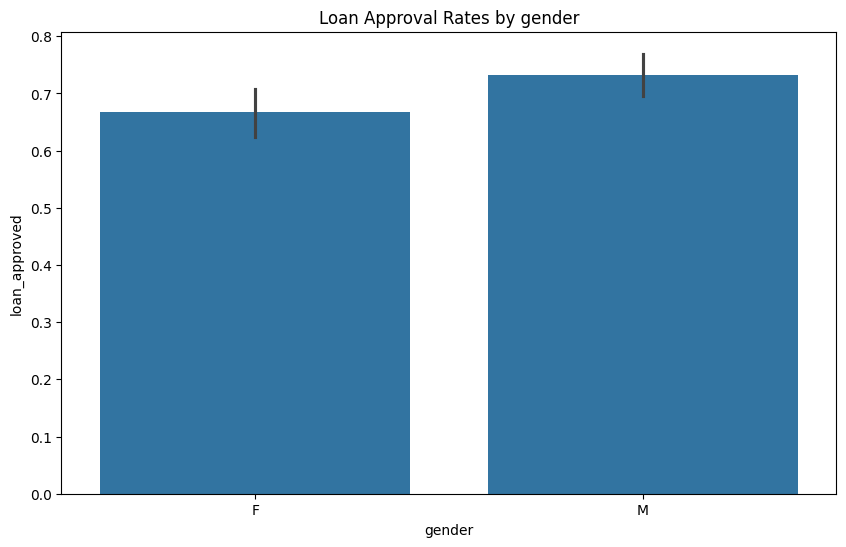


2. Statistical Parity Analysis:
Statistical Parity Difference: 0.0660
Group-wise approval rates: {'F': np.float64(0.6666666666666666), 'M': np.float64(0.7326530612244898)}

3. Disparate Impact Analysis:
Disparate Impact Ratio: 0.9099
(A value of 1.0 indicates perfect fairness)

4. Feature Correlation Analysis:


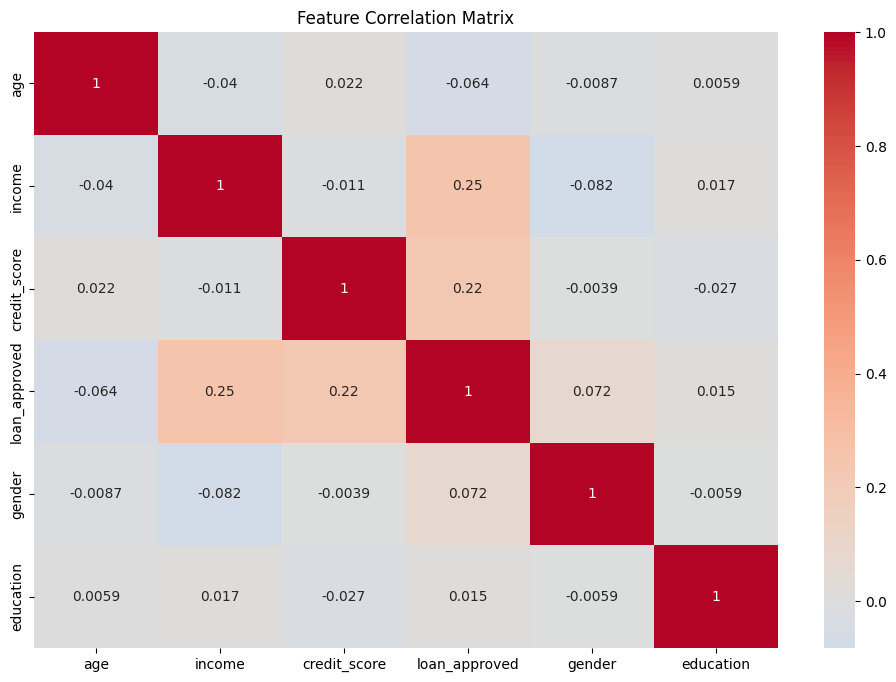


5. Conditional Approval Rate Analysis:


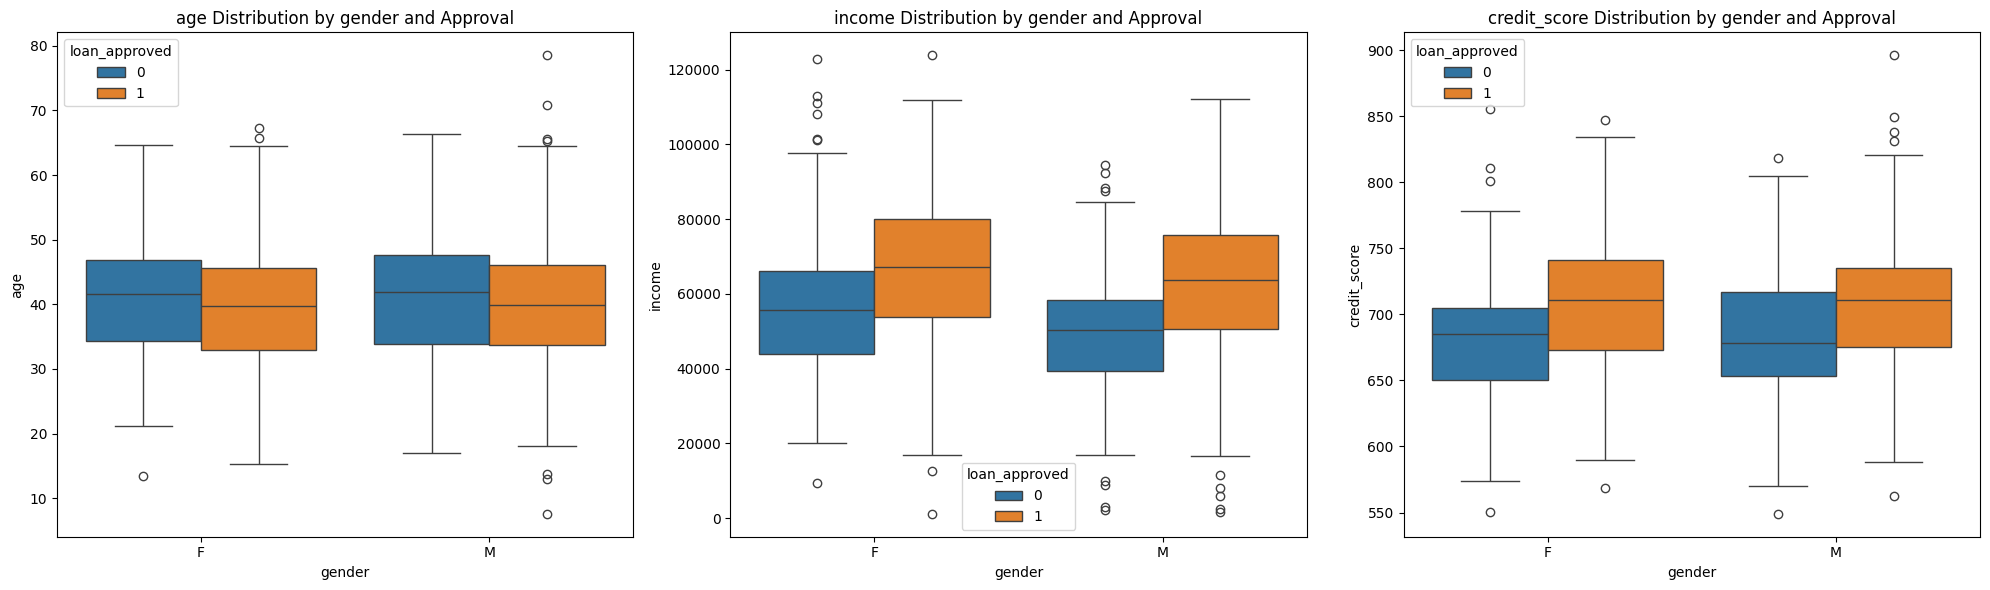


6. Intersectional Analysis:
                  count      mean
education_gender                 
Bachelor_F          163  0.644172
Bachelor_M          166  0.740964
Master_F            177  0.661017
Master_M            156  0.730769
PhD_F               170  0.694118
PhD_M               168  0.726190


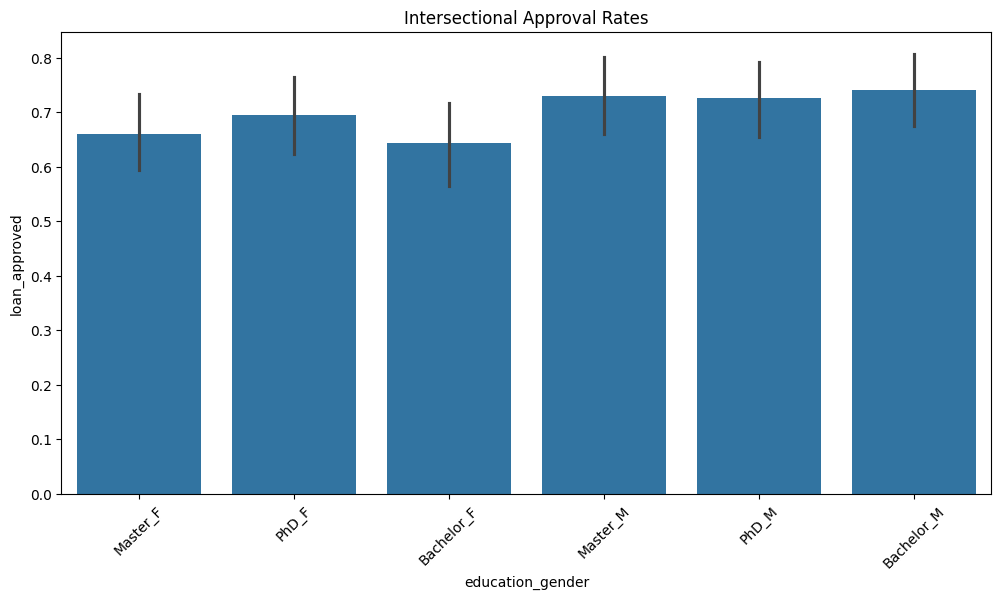


=== Summary Statistics ===
Number of applications: 1000

Group sizes:
gender
F    510
M    490
Name: count, dtype: int64

Overall approval rate: 69.90%

=== Step 2: Bias Mitigation ===

Evaluating Original Metrics...

Applying Reweighing...

Applying Disparate Impact Remover...

=== Summary and Recommendations ===

Bias Detection Results:
- Statistical Parity Difference: 0.0660
- Disparate Impact: 0.9099

Mitigation Results:

Original:
- Disparate Impact: 0.8904
- Statistical Parity Difference: -0.0766

Reweighing:
- Disparate Impact: 1.0000
- Statistical Parity Difference: 0.0000

Disparate_Impact_Remover:
- Disparate Impact: 0.9224
- Statistical Parity Difference: -0.0579

Recommendations:
1. Monitor these metrics regularly in your ML pipeline
2. Consider implementing the most effective mitigation technique based on your requirements
3. Balance fairness metrics with model performance
4. Document all bias-related decisions and their impacts


/var/folders/gl/q2977b1d2f11wv63sxv4cyhh0000gn/T/ipykernel_49781/1278523840.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(techniques, rotation=45)
/var/folders/gl/q2977b1d2f11wv63sxv4cyhh0000gn/T/ipykernel_49781/1278523840.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(techniques, rotation=45)
/var/folders/gl/q2977b1d2f11wv63sxv4cyhh0000gn/T/ipykernel_49781/1278523840.py:111: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


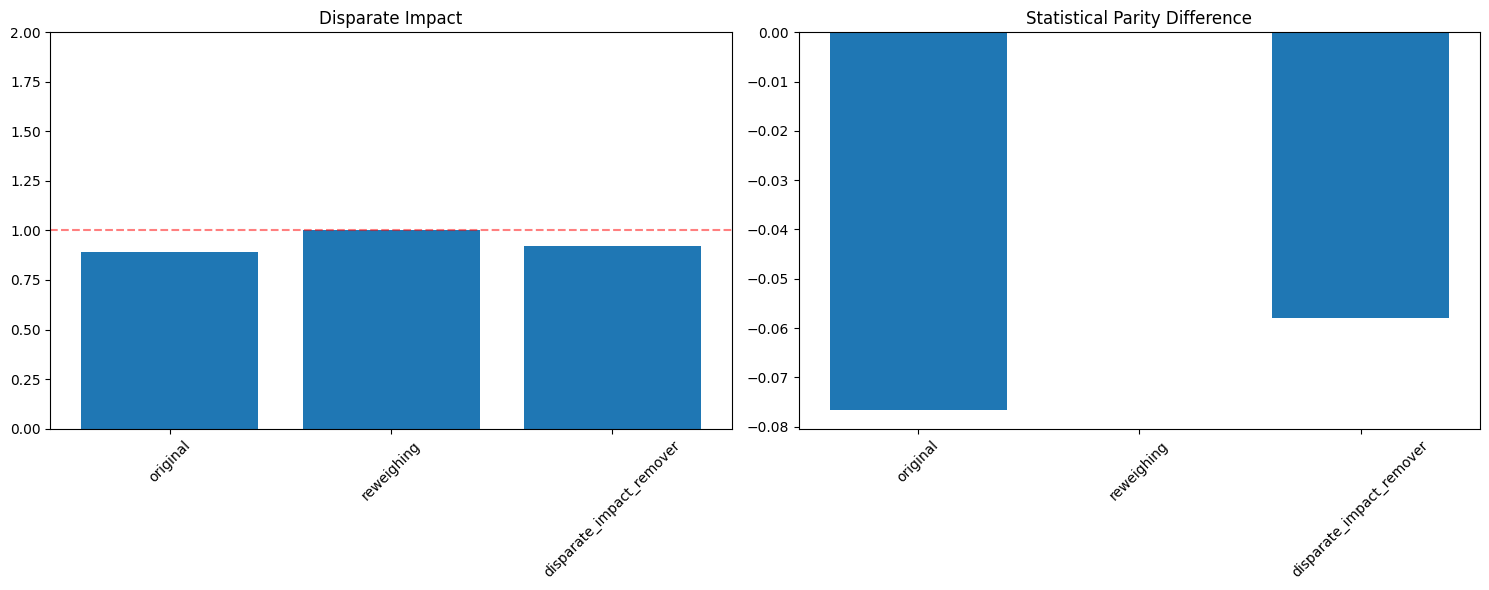

In [6]:
# This script runs the entire bias detection and mitigation analysis process on a synthetic loan approval dataset.
# It follows a series of steps to detect bias, apply mitigation techniques, and provide a summary of results and recommendations.

if __name__ == "__main__":
    # Step 1: Create synthetic loan data
    # Here we generate a synthetic dataset representing loan applicants with features like age, income, credit score, gender, and education.
    df = create_synthetic_loan_data()

    # Step 2: Bias Detection
    # In this step, we analyze the dataset for potential biases based on the protected attribute (e.g., gender).
    # The detect_bias function calculates several fairness metrics like statistical parity and disparate impact.
    print("\n=== Step 1: Bias Detection ===")
    bias_metrics = detect_bias(df)  # Detect bias using the provided function

    # Step 3: Bias Mitigation
    # Once the bias is detected, we apply different bias mitigation techniques (e.g., reweighing, disparate impact remover).
    # These techniques aim to reduce any unfair advantages or disadvantages for specific groups.
    print("\n=== Step 2: Bias Mitigation ===")
    mitigation_results = apply_bias_mitigation_techniques(df, bias_metrics)  # Apply the bias mitigation techniques

    # Step 4: Print Summary and Recommendations
    # After applying the mitigation techniques, we print a summary of the results and provide recommendations for further action.
    print("\n=== Summary and Recommendations ===")

    # Display Bias Detection Results
    # We print the results of the bias detection analysis, including the statistical parity difference and disparate impact ratio.
    print("\nBias Detection Results:")
    print(f"- Statistical Parity Difference: {bias_metrics['statistical_parity']:.4f}")
    print(f"- Disparate Impact: {bias_metrics['disparate_impact']:.4f}")

    # Display Mitigation Results
    # Here, we print the results of each bias mitigation technique applied, including the metrics for disparate impact and statistical parity.
    print("\nMitigation Results:")
    for technique, metrics in mitigation_results.items():
        print(f"\n{technique.title()}:")  # Print the name of the mitigation technique
        print(f"- Disparate Impact: {metrics['disparate_impact']:.4f}")  # Print the disparate impact metric
        print(f"- Statistical Parity Difference: {metrics['statistical_parity_difference']:.4f}")  # Print the statistical parity difference

    # Display Recommendations
    # Provide a list of recommendations based on the analysis to help improve fairness in the model.
    print("\nRecommendations:")
    print("1. Monitor these metrics regularly in your ML pipeline")  # Suggest regular monitoring of fairness metrics
    print("2. Consider implementing the most effective mitigation technique based on your requirements")  # Suggest selecting effective techniques
    print("3. Balance fairness metrics with model performance")  # Suggest balancing fairness with model accuracy
    print("4. Document all bias-related decisions and their impacts")  # Suggest documenting decisions to ensure transparency

The approval rate analysis reveals that females, with 510 applications, have a mean approval rate of 66.67%, while males, with 490 applications, have a higher approval rate of 73.27%. This disparity suggests a potential gender bias in the loan approval process, indicating that male applicants may be more likely to receive approval than female applicants. Further investigation may be needed to ensure fairness.

The Statistical Parity Analysis reveals a Statistical Parity Difference of 0.066, meaning there is a 6.6% difference in loan approval rates between genders. Specifically, females have an approval rate of 66.67%, while males have a higher rate of 73.27%. This difference suggests a slight favoring of male applicants over female applicants.

In the Disparate Impact Analysis, the Disparate Impact Ratio is 0.9099. This ratio, which compares the approval rate of the less favored group (females) to that of the more favored group (males), is below the ideal value of 1.0, indicating some disparity. A ratio of 1.0 would imply perfect fairness, so a 0.9099 ratio suggests that females may be slightly disadvantaged in the loan approval process compared to males.

### Feature Correlation Analysis

The **Feature Correlation Matrix** below shows the relationships between different features in the loan dataset:

- **Income and Loan Approval**: Moderate positive correlation (0.25), suggesting that higher income is associated with a higher likelihood of loan approval.
- **Credit Score and Loan Approval**: Moderate positive correlation (0.22), indicating that a higher credit score may lead to higher approval rates.
- **Gender and Loan Approval**: Weak positive correlation (0.072), hinting at a slight gender bias that might require further examination.
- **Age and Loan Approval**: Very weak negative correlation (-0.064), implying minimal influence of age on approval decisions.

The features **income** and **credit score** are the most influential factors for loan approval in this dataset, while **gender** shows a minor correlation that may require fairness considerations. Other features, such as **education** and **age**, have limited impact on loan approval outcomes.

### Interpretation of Conditional Approval Rate Analysis

The three box plots display the distributions of **age**, **income**, and **credit score** by gender (F and M) and loan approval status (0 for not approved, 1 for approved).

1. **Age Distribution**:
   - The age distributions for approved (orange) and not approved (blue) loans are similar across both genders.
   - This suggests that age does not have a significant impact on loan approval decisions in this dataset.

2. **Income Distribution**:
   - For both genders, applicants with higher incomes tend to have a higher likelihood of loan approval.
   - Males show a slightly higher median income for approved loans compared to females, indicating a potential gender-related income difference in the approval process.

3. **Credit Score Distribution**:
   - Higher credit scores are associated with loan approval across both genders.
   - There is a slight difference between genders, with approved male applicants showing a slightly higher median credit score than approved female applicants.

Income and credit score are key factors influencing loan approval. While age has a minimal effect, the slight differences in income and credit score distributions by gender suggest potential biases that warrant further investigation.

### Intersectional Analysis:

The bar chart below shows **loan approval rates** segmented by both **education level** and **gender**. The x-axis represents combined categories of education and gender (e.g., "Master_F" for females with a Master's degree), and the y-axis indicates the loan approval rate for each group.

#### Key Observations:

1. **Bachelor's Degree Holders**:
   - Male applicants with a Bachelor's degree have a higher approval rate (74.1%) compared to their female counterparts (64.4%).

2. **Master's Degree Holders**:
   - Male Master's degree holders also show a higher approval rate (73.1%) than females with the same degree (66.1%).

3. **PhD Holders**:
   - Both male and female PhD holders have relatively high approval rates, with males at 72.6% and females at 69.4%.

There is a consistent trend where males generally have higher loan approval rates than females across all education levels, especially noticeable among Bachelor's and Master's degree holders. This intersectional analysis suggests potential biases in the approval process, favoring male applicants within similar educational backgrounds.

### Initial Bias Detection Results

- **Statistical Parity Difference**: 0.0660  
  - There is a 6.6% difference in approval rates between groups (male vs. female).
  - Perfect fairness would be 0.0.
  - The positive value suggests males are getting approved more often than females.

- **Disparate Impact**: 0.9099  
  - This ratio represents the approval rate of the disadvantaged group (female) divided by that of the advantaged group (male).
  - Perfect fairness would be 1.0.
  - A value below 1 indicates females are approved at about 91% of the rate of males.
  - This is close to but does not meet the 80% rule (0.8), which is commonly referenced in legal contexts.

---

### Mitigation Results

#### a) Original (Baseline Measurements)
- **Disparate Impact**: 0.8904
- **Statistical Parity Difference**: -0.0766
  - Slightly different from the initial measurements due to train/test split.
  - Shows similar bias patterns to the initial detection.

#### b) Reweighing
- **Disparate Impact**: 1.0000
- **Statistical Parity Difference**: 0.0000
  - Achieved perfect fairness metrics, balancing approval rates between groups.
  - This was the most effective mitigation technique in this case.
  - However, it is important to consider if this level of correction affects the model’s utility.

#### c) Disparate Impact Remover
- **Disparate Impact**: 0.9224
- **Statistical Parity Difference**: -0.0579
  - Showed moderate improvement over the original results.
  - Increased Disparate Impact from 0.89 to 0.92.
  - Reduced Statistical Parity Difference from -0.077 to -0.058.
  - Provided a less aggressive correction than Reweighing.

---

### Key Takeaways

- Initial bias was moderate but detectable.
- **Reweighing** was the most effective technique for achieving statistical parity.
- **Disparate Impact Remover** made improvements but applied a more conservative correction.
- Both mitigation techniques improved fairness metrics.

---

### Recommendations

1. **Use Reweighing** if perfect statistical parity is required.
2. **Consider Disparate Impact Remover** if a more moderate approach is preferred.
3. **Monitor model performance metrics** alongside fairness metrics to ensure balance.
4. **Implement regular bias audits** to ensure that fairness improvements persist over time.
5. **Document trade-offs** between different mitigation approaches for transparency and informed decision-making.
